In [32]:
import os
import argparse
import numpy as np
import pandas as pd
import time
import shutil
from PIL import Image
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.models as models
import torch.nn as nn

class ProtestDatasetEval(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.transform = transforms.Compose([
                                transforms.Resize(125),
                                transforms.CenterCrop(100),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225]),
                                ])
        self.img_list = sorted(os.listdir(img_dir))
    def __len__(self):
        return len(self.img_list)
    def __getitem__(self, idx):
        imgpath = os.path.join(self.img_dir,
                                self.img_list[idx])
        image = pil_loader(imgpath)
        sample = {"imgpath":imgpath, "image":image}
        sample["image"] = self.transform(sample["image"])
        return sample
    
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def modified_resnet():
    model = models.resnet50(pretrained = True)
    model.fc = FinalLayer()
    return model

class FinalLayer(nn.Module):
    def __init__(self):
        super(FinalLayer, self).__init__()
        self.fc = nn.Linear(2048, 12)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc(x)
        out = self.sigmoid(out)
        return out

def eval_one_dir(img_dir, model):
        model.eval()
        dataset = ProtestDatasetEval(img_dir = img_dir)
        data_loader = DataLoader(dataset,
                                num_workers = args.workers,
                                batch_size = args.batch_size)
        outputs = []
        imgpaths = []

        n_imgs = len(os.listdir(img_dir))
        with tqdm(total=n_imgs) as pbar:
            for i, sample in enumerate(data_loader):
                imgpath, input = sample['imgpath'], sample['image']
                if args.cuda:
                    input = input.cuda()

                input_var = Variable(input)
                output = model(input_var)
                outputs.append(output.cpu().data.numpy())
                imgpaths += imgpath
                if i < n_imgs / args.batch_size:
                    pbar.update(args.batch_size)
                else:
                    pbar.update(n_imgs%args.batch_size)


        df = pd.DataFrame(np.zeros((len(os.listdir(img_dir)), 13)))
        df.columns = ["imgpath", "protest", "violence", "sign", "photo",
                      "fire", "police", "children", "group_20", "group_100",
                      "flag", "night", "shouting"]
        df['imgpath'] = imgpaths
        df.iloc[:,1:] = np.concatenate(outputs)
        df.sort_values(by = 'imgpath', inplace=True)
        '''
        decimals = pd.Series([0,2,0,0,0,0,0,0,0,0,0,0], index=["protest", "violence", "sign", "photo",
                      "fire", "police", "children", "group_20", "group_100",
                      "flag", "night", "shouting"])
        df = df.round(decimals)
        '''
        return df

def main():

    print("*** loading model from {model}".format(model = args.model))
    model = modified_resnet()
    if args.cuda:
        model = model.cuda()
    with open(args.model, 'rb') as f:
        model.load_state_dict(torch.load(f)['state_dict'], strict=False)
    print("*** calculating the model output of the images in {img_dir}"
            .format(img_dir = args.img_dir))

    # calculate output
    df = eval_one_dir(args.img_dir, model)

    # write csv file
    df.to_csv(args.output_csvpath, index = False)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--img_dir",
                        type=str,
                        #required = True,
                        default = "test/",
                        help = "image directory to calculate output"
                        "(the directory must contain only image files)"
                        )
    parser.add_argument("--output_csvpath",
                        type=str,
                        default = "result.csv",
                        help = "path to output csv file"
                        )
    parser.add_argument("--model",
                        type=str,
                        #required = True,
                        default = "model_best.pth.tar",
                        help = "model path"
                        )
    parser.add_argument("--cuda",
                        action = "store_true",
                        help = "use cuda?",
                        )
    parser.add_argument("--workers",
                        type = int,
                        default = 0,
                        help = "number of workers",
                        )
    parser.add_argument("--batch_size",
                        type = int,
                        default = 16,
                        help = "batch size",
                        )
    args, unknown = parser.parse_known_args()

    main()

*** loading model from model_best.pth.tar
*** calculating the model output of the images in test/


8112it [07:35, 19.57it/s]                                                                                              


In [33]:
output_csv_path = 'result.csv'

df_pred = pd.read_csv(output_csv_path)
df_pred['imgpath'] = df_pred['imgpath'].apply(os.path.basename)


test_label_path = 'annot_test.txt'
df_target = pd.read_csv(test_label_path, delimiter= '\t')

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
def plot_roc(attr, target, pred):
    """Plot a ROC curve and show the accuracy score and the AUC"""
    fig, ax = plt.subplots()
    auc = roc_auc_score(target, pred)
    acc = accuracy_score(target, (pred >= 0.5).astype(int))
    fpr, tpr, _ = roc_curve(target, pred)
    plt.plot(fpr, tpr,'r', lw = 2)
    plt.title(('ROC Curve for {attr} (Accuracy = {acc:.2f}, AUC = {auc:.2f})'
               .format(attr = attr.title(), acc= acc, auc = auc)),
              fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 10)
    plt.ylabel('True Positive Rate', fontsize = 10)
    plt.show()
    return fig

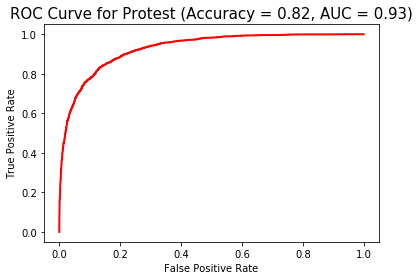

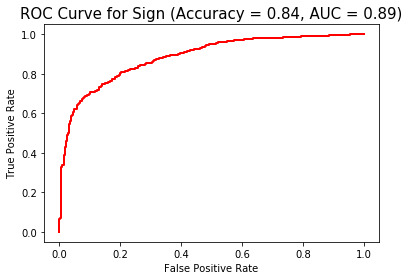

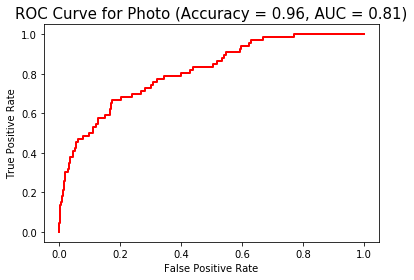

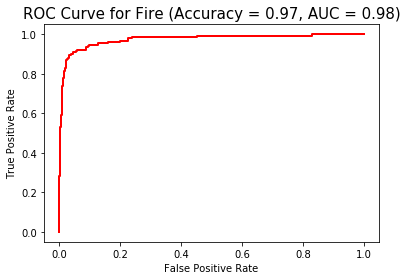

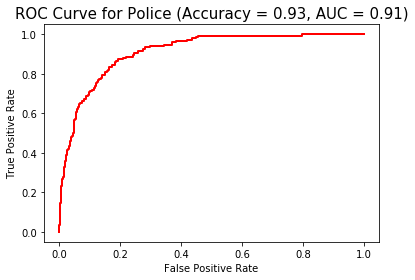

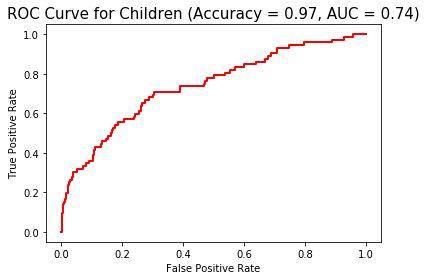

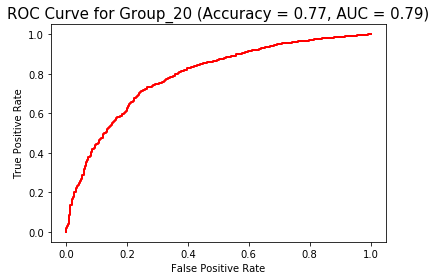

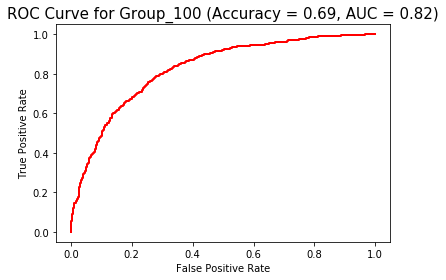

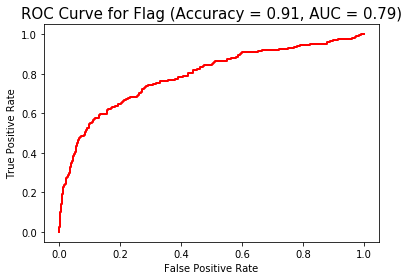

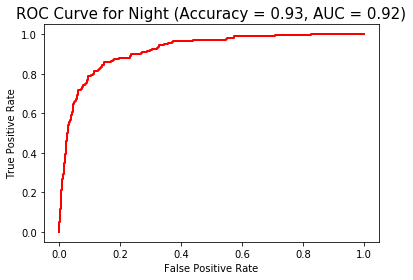

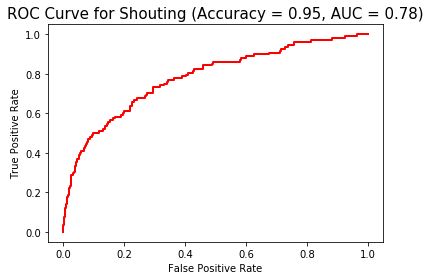

In [35]:
attr = "protest"
target = df_target[attr]
pred = df_pred[attr]
fig = plot_roc(attr, target, pred)
fig.savefig(os.path.join('', attr+'.png'))
# plot ROC curves for visual attributes
for attr in df_pred.columns[3:]:
    target = df_target[attr]
    pred = df_pred[attr][target != '-']
    target = target[target != '-'].astype(int)
    fig = plot_roc(attr, target, pred)
    fig.savefig(os.path.join('', attr+'.png'))

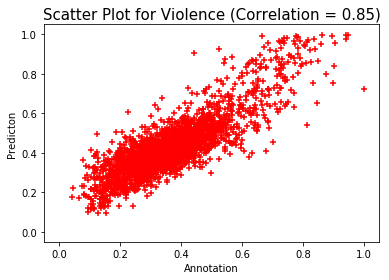

In [10]:
import scipy.stats as stats
attr = 'violence'
pred = df_pred[df_target['protest'] == 1][attr].tolist()
target = df_target[df_target['protest'] == 1][attr].astype(float).tolist()
fig, ax = plt.subplots()
plt.scatter(target, pred,c='r',marker = '+',label = attr.title())
plt.xlim([-.05,1.05])
plt.ylim([-.05,1.05])
plt.xlabel('Annotation', fontsize = 10)
plt.ylabel('Predicton', fontsize = 10)
corr, pval = stats.pearsonr(target, pred)
plt.title(('Scatter Plot for {attr} (Correlation = {corr:.2f})'
            .format(attr = attr.title(), corr= corr)), fontsize = 15)
plt.show()
fig.savefig(os.path.join('', attr+'.png'))